# Install AutoGluon

In [1]:
!pip install autogluon.timeseries
!pip uninstall torchaudio torchvision torchtext -y  # fix incompatible package versions on Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.5/308.5 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

# Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

## Helper Functions

In [4]:
def load_csv_day_ahead_prices(year):
  region = 3

  df = pd.read_csv(f'dap-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['MTU (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['MTU (CET/CEST)', f'BZN|SE{region}', 'Currency'],
    inplace=True
  )

  return df

def day_ahead_prices(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_day_ahead_prices(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [5]:
def load_csv_total_load_forecast(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Actual Total Load [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}': 'Day-ahead Total Load Forecast [MW]' },
    inplace=True
  )

  return df

def total_load_forecast(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_forecast(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [6]:
def load_csv_total_load_actual(year):
  region = 3

  df = pd.read_csv(f'tl-se{region}-{year}.csv')
  df.index = pd.to_datetime(
    df['Time (CET/CEST)'].str.split(' - ').str[0],
    format='%d.%m.%Y %H:%M'
  )
  df.drop(
    columns=['Time (CET/CEST)', f'Day-ahead Total Load Forecast [MW] - BZN|SE{region}'],
    inplace=True
  )
  df.rename(
    columns={ f'Actual Total Load [MW] - BZN|SE{region}': 'Actual Total Load [MW]' },
    inplace=True
  )

  return df

def total_actual_load(start=2015, end_incl=2023):
  region = 3

  df = pd.concat([load_csv_total_load_actual(year) for year in range(start, end_incl + 1)])
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

In [7]:
# SMHI files are cut to range from 2015-2023
def load_smhi(filename):
  df = pd.read_csv(filename, delimiter=';', quoting=3)
  df.index = pd.to_datetime(
    df['Datum'] + " " + df['Tid (UTC)'],
    format='%Y-%m-%d %H:%M:%S'
  )
  df.drop(
    columns=['Datum', 'Tid (UTC)', 'Kvalitet'],
    inplace=True
  )

  df = df.resample('1H').asfreq()
  df = df.ffill()
  df = df[~df.index.duplicated(keep='first')]

  return df

## Loading in Data

In [8]:
start_year = 2019
end_year = 2023

df = day_ahead_prices(start=start_year, end_incl=end_year)
df.reset_index(inplace=True)

df['item_id'] = 0

df

,MTU (CET/CEST),Day-ahead Price [EUR/MWh],item_id
0,2019-01-01 00:00:00,28.32,0
1,2019-01-01 01:00:00,10.07,0
2,2019-01-01 02:00:00,10.03,0
3,2019-01-01 03:00:00,4.56,0
4,2019-01-01 04:00:00,4.83,0
...,...,...,...
43819,2023-12-31 19:00:00,39.64,0
43820,2023-12-31 20:00:00,34.89,0
43821,2023-12-31 21:00:00,29.60,0
43822,2023-12-31 22:00:00,28.67,0


## Mirror Logarithm

In [9]:
def mlog(df, c=1/3):
  return np.sign(df) * (np.log(1 / c + np.abs(df)) + np.log(c))

def mlog_inv(df, c=1/3):
  return np.sign(df) * (np.exp(np.abs(df) - np.log(c)) - 1 / c)

In [10]:
df['price_log'] = mlog(df['Day-ahead Price [EUR/MWh]'])
df.drop(columns=['Day-ahead Price [EUR/MWh]'], inplace=True)
df

,MTU (CET/CEST),item_id,price_log
0,2019-01-01 00:00:00,0,2.345645
1,2019-01-01 01:00:00,0,1.471707
2,2019-01-01 02:00:00,0,1.468642
3,2019-01-01 03:00:00,0,0.924259
4,2019-01-01 04:00:00,0,0.959350
...,...,...,...
43819,2023-12-31 19:00:00,0,2.654180
43820,2023-12-31 20:00:00,0,2.536075
43821,2023-12-31 21:00:00,0,2.385700
43822,2023-12-31 22:00:00,0,2.356758


# Covariates

In [11]:
actual_load = total_actual_load(start=start_year, end_incl=end_year).reset_index()
predicted_load = total_load_forecast(start=start_year, end_incl=end_year).reset_index()

df['Actual Load'] = actual_load['Actual Total Load [MW]']
df['Predicted Load'] = predicted_load['Day-ahead Total Load Forecast [MW]']

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load
0,2019-01-01 00:00:00,0,2.345645,9212.0,9167.0
1,2019-01-01 01:00:00,0,1.471707,9057.0,8968.0
2,2019-01-01 02:00:00,0,1.468642,8949.0,8759.0
3,2019-01-01 03:00:00,0,0.924259,8812.0,8635.0
4,2019-01-01 04:00:00,0,0.959350,8804.0,8549.0
...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.654180,11947.0,11877.0
43820,2023-12-31 20:00:00,0,2.536075,11561.0,11563.0
43821,2023-12-31 21:00:00,0,2.385700,11276.0,11350.0
43822,2023-12-31 22:00:00,0,2.356758,11035.0,11099.0


In [12]:
df['month'] = df['MTU (CET/CEST)'].dt.month
df['weekday'] = df['MTU (CET/CEST)'].dt.weekday
df['hour'] = df['MTU (CET/CEST)'].dt.hour

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour
0,2019-01-01 00:00:00,0,2.345645,9212.0,9167.0,1,1,0
1,2019-01-01 01:00:00,0,1.471707,9057.0,8968.0,1,1,1
2,2019-01-01 02:00:00,0,1.468642,8949.0,8759.0,1,1,2
3,2019-01-01 03:00:00,0,0.924259,8812.0,8635.0,1,1,3
4,2019-01-01 04:00:00,0,0.959350,8804.0,8549.0,1,1,4
...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.654180,11947.0,11877.0,12,6,19
43820,2023-12-31 20:00:00,0,2.536075,11561.0,11563.0,12,6,20
43821,2023-12-31 21:00:00,0,2.385700,11276.0,11350.0,12,6,21
43822,2023-12-31 22:00:00,0,2.356758,11035.0,11099.0,12,6,22


In [13]:
solar_df = load_smhi('smhi-solar-radiation-stockholmsol.csv').reset_index()
temperature_df = load_smhi('smhi-temperature-bma.csv').reset_index()
windspeed_df = load_smhi('smhi-windspeed-bma.csv').drop(columns=['Vindriktning', 'Kvalitet.1']).reset_index()

df['Solar Radiation'] = solar_df.loc[solar_df['index'] >= f'{start_year}-01-01']['Global Irradians'].values
df['Temperature'] = temperature_df.loc[temperature_df['index'] >= f'{start_year}-01-01']['Lufttemperatur'].values
df['Windspeed'] = windspeed_df.loc[windspeed_df['index'] >= f'{start_year}-01-01']['Vindhastighet'].values

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2019-01-01 00:00:00,0,2.345645,9212.0,9167.0,1,1,0,0.0,4.2,3.0
1,2019-01-01 01:00:00,0,1.471707,9057.0,8968.0,1,1,1,0.0,5.6,5.0
2,2019-01-01 02:00:00,0,1.468642,8949.0,8759.0,1,1,2,0.0,6.2,6.0
3,2019-01-01 03:00:00,0,0.924259,8812.0,8635.0,1,1,3,0.0,6.6,6.0
4,2019-01-01 04:00:00,0,0.959350,8804.0,8549.0,1,1,4,0.0,5.8,3.0
...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,2.654180,11947.0,11877.0,12,6,19,0.0,-2.4,4.0
43820,2023-12-31 20:00:00,0,2.536075,11561.0,11563.0,12,6,20,0.0,-2.3,3.0
43821,2023-12-31 21:00:00,0,2.385700,11276.0,11350.0,12,6,21,0.0,-2.3,4.0
43822,2023-12-31 22:00:00,0,2.356758,11035.0,11099.0,12,6,22,0.0,-2.1,3.0


## Scaling down

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df[['price_log']] = scaler.fit_transform(df[['price_log']])
df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']] = MinMaxScaler().fit_transform(df[['Actual Load', 'Predicted Load', 'Solar Radiation', 'Temperature', 'Windspeed']])

df

,MTU (CET/CEST),item_id,price_log,Actual Load,Predicted Load,month,weekday,hour,Solar Radiation,Temperature,Windspeed
0,2019-01-01 00:00:00,0,0.624307,0.370550,0.344278,1,1,0,0.0,0.438976,0.250000
1,2019-01-01 01:00:00,0,0.523096,0.357597,0.327307,1,1,1,0.0,0.466535,0.416667
2,2019-01-01 02:00:00,0,0.522741,0.348571,0.309483,1,1,2,0.0,0.478346,0.500000
3,2019-01-01 03:00:00,0,0.459697,0.337122,0.298908,1,1,3,0.0,0.486220,0.500000
4,2019-01-01 04:00:00,0,0.463760,0.336453,0.291574,1,1,4,0.0,0.470472,0.250000
...,...,...,...,...,...,...,...,...,...,...,...
43819,2023-12-31 19:00:00,0,0.660038,0.599114,0.575388,12,6,19,0.0,0.309055,0.333333
43820,2023-12-31 20:00:00,0,0.646360,0.566856,0.548610,12,6,20,0.0,0.311024,0.250000
43821,2023-12-31 21:00:00,0,0.628945,0.543039,0.530445,12,6,21,0.0,0.311024,0.333333
43822,2023-12-31 22:00:00,0,0.625594,0.522898,0.509040,12,6,22,0.0,0.314961,0.250000


# Create the AutoGluon Timeseries

In [15]:
series = TimeSeriesDataFrame.from_data_frame(
  df,
  id_column='item_id',
  timestamp_column='MTU (CET/CEST)'
)

series['month'] = series['month'].astype('category')
series['weekday'] = series['weekday'].astype('category')
series['hour'] = series['hour'].astype('category')

series.head()

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2019-01-01 00:00:00   0.624307     0.370550        0.344278     1   
        2019-01-01 01:00:00   0.523096     0.357597        0.327307     1   
        2019-01-01 02:00:00   0.522741     0.348571        0.309483     1   
        2019-01-01 03:00:00   0.459697     0.337122        0.298908     1   
        2019-01-01 04:00:00   0.463760     0.336453        0.291574     1   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.438976   
        2019-01-01 01:00:00       1    1              0.0     0.466535   
        2019-01-01 02:00:00       1    2              0.0     0.478346   
        2019-01-01 03:00:00       1    3              0.0     0.486220   
        2019-01-01 04:00:00       1    4              0.0     0.470472   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000

In [16]:
cutoff = pd.Timestamp(f'{end_year}-01-01')
train, test = series.split_by_time(cutoff)

train

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2019-01-01 00:00:00   0.624307     0.370550        0.344278     1   
        2019-01-01 01:00:00   0.523096     0.357597        0.327307     1   
        2019-01-01 02:00:00   0.522741     0.348571        0.309483     1   
        2019-01-01 03:00:00   0.459697     0.337122        0.298908     1   
        2019-01-01 04:00:00   0.463760     0.336453        0.291574     1   
...                                ...          ...             ...   ...   
        2022-12-31 19:00:00   0.560675     0.441083        0.427341    12   
        2022-12-31 20:00:00   0.535678     0.403142        0.394764    12   
        2022-12-31 21:00:00   0.559452     0.373809        0.371823    12   
        2022-12-31 22:00:00   0.521939     0.360521        0.356899    12   
        2022-12-31 23:00:00   0.463908     0.348153        0.340525    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2019-01-01 00:00:00       1    0              0.0     0.438976   
        2019-01-01 01:00:00       1    1              0.0     0.466535   
        2019-01-01 02:00:00       1    2              0.0     0.478346   
        2019-01-01 03:00:00       1    3              0.0     0.486220   
        2019-01-01 04:00:00       1    4              0.0     0.470472   
...                             ...  ...              ...          ...   
        2022-12-31 19:00:00       5   19              0.0     0.478346   
        2022-12-31 20:00:00       5   20              0.0     0.466535   
        2022-12-31 21:00:00       5   21              0.0     0.452756   
        2022-12-31 22:00:00       5   22              0.0     0.444882   
        2022-12-31 23:00:00       5   23              0.0     0.423228   

                             Windspeed  
item_id timestamp                       
0       2019-01-01 00:00:00   0.250000  
        2019-01-01 01:00:00   0.416667  
        2019-01-01 02:00:00   0.500000  
        2019-01-01 03:00:00   0.500000  
        2019-01-01 04:00:00   0.250000  
...                                ...  
        2022-12-31 19:00:00   0.333333  
        2022-12-31 20:00:00   0.250000  
        2022-12-31 21:00:00   0.250000  
        2022-12-31 22:00:00   0.333333  
        2022-12-31 23:00:00   0.250000  

[35064 rows x 9 columns]

In [17]:
test

price_log  Actual Load  Predicted Load month  \
item_id timestamp                                                           
0       2023-01-01 00:00:00   0.412048     0.349072        0.328927     1   
        2023-01-01 01:00:00   0.396485     0.348070        0.321252     1   
        2023-01-01 02:00:00   0.356082     0.346900        0.316050     1   
        2023-01-01 03:00:00   0.355706     0.343390        0.311189     1   
        2023-01-01 04:00:00   0.354573     0.341050        0.313491     1   
...                                ...          ...             ...   ...   
        2023-12-31 19:00:00   0.660038     0.599114        0.575388    12   
        2023-12-31 20:00:00   0.646360     0.566856        0.548610    12   
        2023-12-31 21:00:00   0.628945     0.543039        0.530445    12   
        2023-12-31 22:00:00   0.625594     0.522898        0.509040    12   
        2023-12-31 23:00:00   0.618817     0.505850        0.490960    12   

                            weekday hour  Solar Radiation  Temperature  \
item_id timestamp                                                        
0       2023-01-01 00:00:00       6    0              0.0     0.413386   
        2023-01-01 01:00:00       6    1              0.0     0.405512   
        2023-01-01 02:00:00       6    2              0.0     0.385827   
        2023-01-01 03:00:00       6    3              0.0     0.374016   
        2023-01-01 04:00:00       6    4              0.0     0.354331   
...                             ...  ...              ...          ...   
        2023-12-31 19:00:00       6   19              0.0     0.309055   
        2023-12-31 20:00:00       6   20              0.0     0.311024   
        2023-12-31 21:00:00       6   21              0.0     0.311024   
        2023-12-31 22:00:00       6   22              0.0     0.314961   
        2023-12-31 23:00:00       6   23              0.0     0.316929   

                             Windspeed  
item_id timestamp                       
0       2023-01-01 00:00:00   0.166667  
        2023-01-01 01:00:00   0.166667  
        2023-01-01 02:00:00   0.083333  
        2023-01-01 03:00:00   0.083333  
        2023-01-01 04:00:00   0.083333  
...                                ...  
        2023-12-31 19:00:00   0.333333  
        2023-12-31 20:00:00   0.250000  
        2023-12-31 21:00:00   0.333333  
        2023-12-31 22:00:00   0.250000  
        2023-12-31 23:00:00   0.333333  

[8760 rows x 9 columns]

# Model Creation

In [18]:
predictor = TimeSeriesPredictor(
  prediction_length=24,
  freq="H",
  path="autogluon-day-ahead",
  target="price_log",
  eval_metric="MSE",
)

predictor.fit(
  train,
  num_val_windows=120,
  refit_every_n_windows=None,
  val_step_size=72,
  presets="high_quality",
  time_limit=1500,
)

Beginning AutoGluon training... Time limit = 1500s
AutoGluon will save models to 'autogluon-day-ahead'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023
CPU Count:          2
GPU Count:          1
Memory Avail:       11.31 GB / 12.67 GB (89.2%)
Disk Space Avail:   45.74 GB / 78.19 GB (58.5%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'freq': 'H',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 120,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'price_log',
 'time_limit': 1500,
 'val_step_size': 72,
 'verbosity': 2}

Provided train_data has 35064 rows, 1 time series. Median time seri

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-0.0075       = Validation score (-MSE)
	128.21  s     = Training runtime
	0.83    s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 158.8s of the 635.4s of remaining time.
	-0.0100       = Validation score (-MSE)
	155.56  s     = Training runtime
	0.07    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 159.9s of the 479.7s of remaining time.
	-0.0090       = Validation score (-MSE)
	166.46  s     = Training runtime
	0.15    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 156.5s of the 313.1s of remaining time.
	-0.0096       = Validation score (-MSE)
	52.36   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'Chronos[base]': 0.53, 'DirectTabular': 0.13, 'NPTS': 0.05, 'PatchTST': 0.03, 'RecursiveTabular': 0.16, 'TemporalFusionTransformer': 0.11}
	-0.0070   

# Prediction Time

In [19]:
history = series.slice_by_time(pd.Timestamp(f'{end_year - 1}-12-30'), pd.Timestamp(f'{end_year}-01-01'))
prediction = predictor.predict(history, model='WeightedEnsemble')
prediction

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.455389  0.413888  0.425003  0.434734  0.445872   
        2023-01-01 01:00:00  0.427780  0.375927  0.383569  0.400949  0.413046   
        2023-01-01 02:00:00  0.410959  0.364809  0.373841  0.381750  0.386234   
        2023-01-01 03:00:00  0.396137  0.351125  0.359864  0.369305  0.374970   
        2023-01-01 04:00:00  0.402634  0.346151  0.356271  0.366761  0.378377   
        2023-01-01 05:00:00  0.433069  0.352693  0.363836  0.390911  0.410173   
        2023-01-01 06:00:00  0.470379  0.364890  0.390061  0.414494  0.453657   
        2023-01-01 07:00:00  0.502952  0.375786  0.431505  0.453089  0.488852   
        2023-01-01 08:00:00  0.524546  0.415612  0.459190  0.499431  0.522106   
        2023-01-01 09:00:00  0.534149  0.437905  0.458260  0.493476  0.522618   
        2023-01-01 10:00:00  0.531284  0.415491  0.463786  0.495045  0.528602   
        2023-01-01 11:00:00  0.532233  0.426581  0.463264  0.499013  0.515568   
        2023-01-01 12:00:00  0.543244  0.451082  0.486639  0.509521  0.530852   
        2023-01-01 13:00:00  0.545428  0.469682  0.494787  0.520442  0.532783   
        2023-01-01 14:00:00  0.557906  0.465899  0.516209  0.536334  0.550220   
        2023-01-01 15:00:00  0.572540  0.482983  0.527609  0.554419  0.565951   
        2023-01-01 16:00:00  0.577415  0.468537  0.535604  0.561798  0.574770   
        2023-01-01 17:00:00  0.586384  0.506700  0.541116  0.561878  0.577715   
        2023-01-01 18:00:00  0.590632  0.521230  0.547607  0.566130  0.580143   
        2023-01-01 19:00:00  0.577049  0.507947  0.539145  0.555412  0.567649   
        2023-01-01 20:00:00  0.560344  0.482728  0.509843  0.534238  0.553383   
        2023-01-01 21:00:00  0.548282  0.470893  0.495290  0.517025  0.535330   
        2023-01-01 22:00:00  0.511924  0.431546  0.450292  0.475528  0.491066   
        2023-01-01 23:00:00  0.468255  0.390112  0.411906  0.432826  0.445221   

                                  0.5       0.6       0.7       0.8       0.9  
item_id timestamp                                                              
0       2023-01-01 00:00:00  0.457298  0.460698  0.474309  0.481655  0.498242  
        2023-01-01 01:00:00  0.426406  0.439555  0.450238  0.458318  0.469383  
        2023-01-01 02:00:00  0.397710  0.419274  0.435332  0.446782  0.459328  
        2023-01-01 03:00:00  0.387795  0.399690  0.412380  0.433978  0.447859  
        2023-01-01 04:00:00  0.390680  0.412263  0.431891  0.453116  0.466096  
        2023-01-01 05:00:00  0.427823  0.451270  0.466888  0.498016  0.513750  
        2023-01-01 06:00:00  0.478382  0.498472  0.520978  0.534734  0.566579  
        2023-01-01 07:00:00  0.522887  0.531751  0.555218  0.574815  0.595691  
        2023-01-01 08:00:00  0.534058  0.561535  0.576554  0.591320  0.604661  
        2023-01-01 09:00:00  0.549893  0.573948  0.588315  0.599043  0.613171  
        2023-01-01 10:00:00  0.551195  0.566291  0.584364  0.595425  0.609864  
        2023-01-01 11:00:00  0.545158  0.574343  0.582717  0.592195  0.607847  
        2023-01-01 12:00:00  0.549320  0.571384  0.588381  0.598266  0.615601  
        2023-01-01 13:00:00  0.547904  0.565539  0.586718  0.597582  0.613626  
        2023-01-01 14:00:00  0.565967  0.584435  0.597494  0.607793  0.623823  
        2023-01-01 15:00:00  0.582162  0.595959  0.604511  0.617701  0.633553  
        2023-01-01 16:00:00  0.586839  0.597459  0.608399  0.623888  0.642680  
        2023-01-01 17:00:00  0.591696  0.601365  0.612683  0.627277  0.646234  
        2023-01-01 18:00:00  0.593639  0.602646  0.613367  0.626680  0.646930  
        2023-01-01 19:00:00  0.576450  0.594001  0.602953  0.615611  0.634770  
        2023-01-01 20:00:00  0.566240  0.583839  0.595479  0.608498  0.632540  
        2023-01-01 21:00:00  0.556917  0.568946  0.582850  0.600214  0.616984  
      

## Predicting the Test Set

In [20]:
forecasts = []

for day in pd.date_range(f'{end_year}-01-01', f'{end_year}-12-31'):
  print(f'Forecasting day {day.strftime("%Y-%m-%d")}')
  history = series.slice_by_time(day - pd.DateOffset(days=2), day)
  forecast = predictor.predict(history, model='WeightedEnsemble')
  forecasts.append(forecast)

forecasts = pd.concat(forecasts)

Forecasting day 2023-01-01
Forecasting day 2023-01-02
Forecasting day 2023-01-03
Forecasting day 2023-01-04
Forecasting day 2023-01-05
Forecasting day 2023-01-06
Forecasting day 2023-01-07
Forecasting day 2023-01-08
Forecasting day 2023-01-09
Forecasting day 2023-01-10
Forecasting day 2023-01-11
Forecasting day 2023-01-12
Forecasting day 2023-01-13
Forecasting day 2023-01-14
Forecasting day 2023-01-15
Forecasting day 2023-01-16
Forecasting day 2023-01-17
Forecasting day 2023-01-18
Forecasting day 2023-01-19
Forecasting day 2023-01-20
Forecasting day 2023-01-21
Forecasting day 2023-01-22
Forecasting day 2023-01-23
Forecasting day 2023-01-24
Forecasting day 2023-01-25
Forecasting day 2023-01-26
Forecasting day 2023-01-27
Forecasting day 2023-01-28
Forecasting day 2023-01-29
Forecasting day 2023-01-30
Forecasting day 2023-01-31
Forecasting day 2023-02-01
Forecasting day 2023-02-02
Forecasting day 2023-02-03
Forecasting day 2023-02-04
Forecasting day 2023-02-05
Forecasting day 2023-02-06
F

Looks promising!

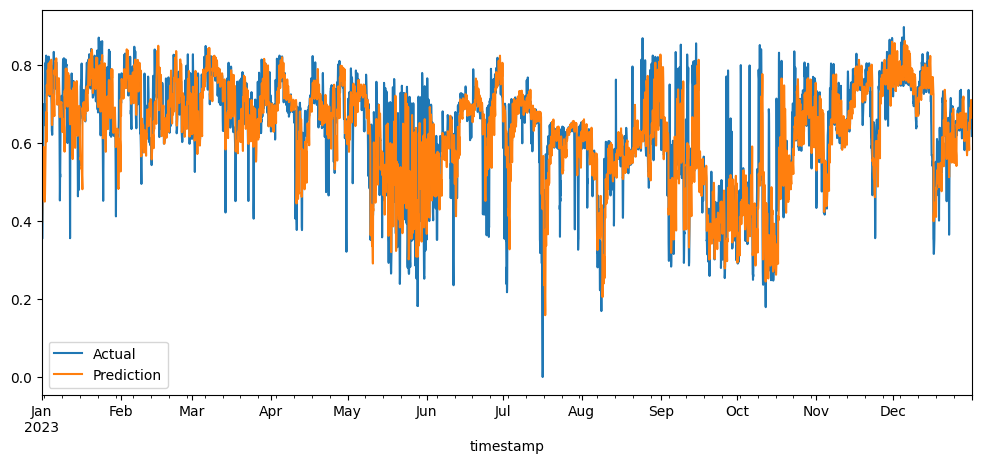

In [21]:
plt.figure(figsize=(12, 5))
test.loc[0]['price_log'].plot(label='Actual')
forecasts.loc[0]['mean'].plot(label='Prediction')
plt.legend()

## Zooming in on a Month

(466008.0, 466752.0)

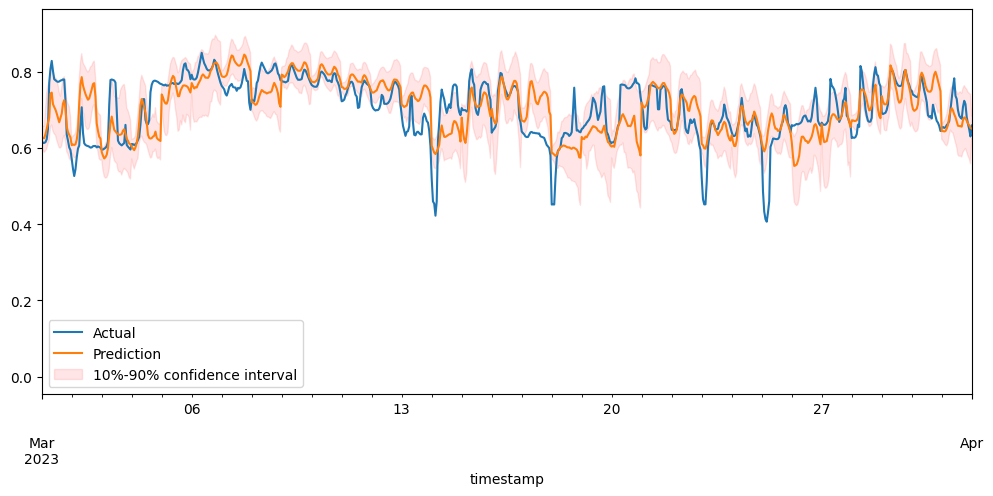

In [22]:
plt.figure(figsize=(12, 5))

y_pred = forecasts.loc[0]
y_test = test.loc[0]

y_test['price_log'].plot(label='Actual')
y_pred['mean'].plot(label='Prediction')

plt.fill_between(
  y_pred.index,
  y_pred["0.1"],
  y_pred["0.9"],
  color="red",
  alpha=0.1,
  label=f"10%-90% confidence interval"
)
plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Scaling Back

In [23]:
forecasts['Forecasted Price'] = mlog_inv(scaler.inverse_transform(forecasts['mean'].values.reshape(-1, 1)))
forecasts

mean       0.1       0.2       0.3       0.4  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.455389  0.413888  0.425003  0.434734  0.445872   
        2023-01-01 01:00:00  0.427780  0.375927  0.383569  0.400949  0.413046   
        2023-01-01 02:00:00  0.410959  0.364809  0.373841  0.381750  0.386234   
        2023-01-01 03:00:00  0.396137  0.351125  0.359864  0.369305  0.374970   
        2023-01-01 04:00:00  0.402634  0.346151  0.356271  0.366761  0.378377   
...                               ...       ...       ...       ...       ...   
        2023-12-31 19:00:00  0.703942  0.635476  0.651406  0.666577  0.680543   
        2023-12-31 20:00:00  0.699025  0.628908  0.646838  0.659496  0.674316   
        2023-12-31 21:00:00  0.690656  0.614753  0.632066  0.648375  0.669075   
        2023-12-31 22:00:00  0.682280  0.603964  0.622808  0.638961  0.657569   
        2023-12-31 23:00:00  0.665869  0.597337  0.609684  0.619669  0.630062   

                                  0.5       0.6       0.7       0.8       0.9  \
item_id timestamp                                                               
0       2023-01-01 00:00:00  0.457298  0.460698  0.474309  0.481655  0.498242   
        2023-01-01 01:00:00  0.426406  0.439555  0.450238  0.458318  0.469383   
        2023-01-01 02:00:00  0.397710  0.419274  0.435332  0.446782  0.459328   
        2023-01-01 03:00:00  0.387795  0.399690  0.412380  0.433978  0.447859   
        2023-01-01 04:00:00  0.390680  0.412263  0.431891  0.453116  0.466096   
...                               ...       ...       ...       ...       ...   
        2023-12-31 19:00:00  0.703695  0.714955  0.735259  0.753115  0.782982   
        2023-12-31 20:00:00  0.698467  0.713129  0.728492  0.750416  0.780197   
        2023-12-31 21:00:00  0.690138  0.700789  0.720068  0.750529  0.773905   
        2023-12-31 22:00:00  0.672745  0.689672  0.709036  0.751053  0.765393   
        2023-12-31 23:00:00  0.660283  0.669311  0.687629  0.729729  0.749267   

                             Forecasted Price  
item_id timestamp                              
0       2023-01-01 00:00:00          4.283955  
        2023-01-01 01:00:00          2.738970  
        2023-01-01 02:00:00          1.963103  
        2023-01-01 03:00:00          1.366841  
        2023-01-01 04:00:00          1.618856  
...                                       ...  
        2023-12-31 19:00:00         59.295756  
        2023-12-31 20:00:00         56.706346  
        2023-12-31 21:00:00         52.543720  
        2023-12-31 22:00:00         48.668478  
        2023-12-31 23:00:00         41.841905  

[8760 rows x 11 columns]

# Predictions vs Actual Dataset

(466008.0, 466752.0)

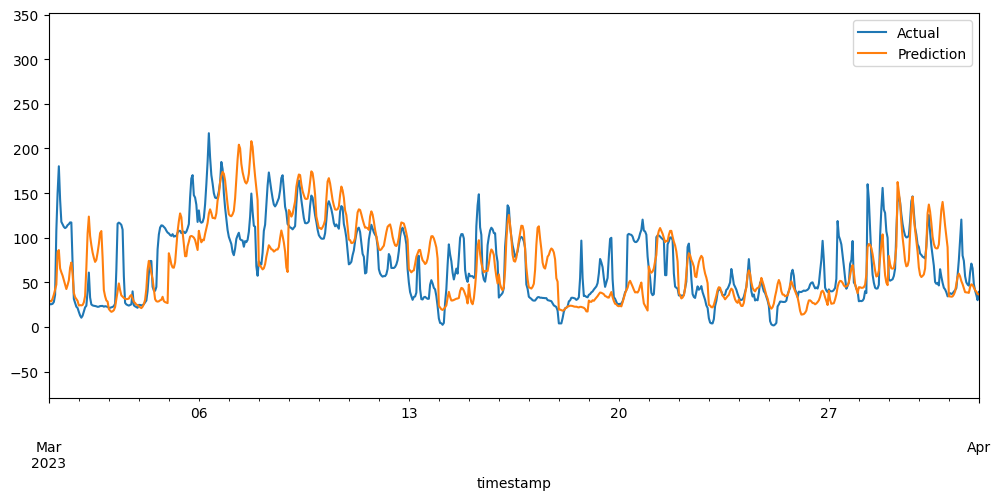

In [24]:
plt.figure(figsize=(12, 5))

actual_prices = day_ahead_prices(start=end_year, end_incl=end_year)
y_pred = forecasts.loc[0]

actual_prices['Day-ahead Price [EUR/MWh]'].plot(label='Actual')
y_pred['Forecasted Price'].plot(label='Prediction')

plt.legend()

plt.xlim(
  left=y_test.index[0] + pd.DateOffset(months=2),
  right=y_test.index[0] + pd.DateOffset(months=3)
)

# Evaluation
For simplicity's sake, let's use Darts to evaluate the performance, just to be consistent with other models.

Hack to circumvent error.

Source https://github.com/googlecolab/colabtools/issues/3409

In [25]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [26]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.9 MB/s eta 0:00:00
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=fbd8e80e2d8f302ba865042e06f16f2d41aa97fc57fe0939da1d253819d773a2
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


In [27]:
from darts.metrics.metrics import _get_values_or_raise

def wape(actual_series, pred_series):
  y_true, y_hat = _get_values_or_raise(actual_series, pred_series, intersect=True, remove_nan_union=True)
  return 100.0 * np.sum(np.abs(y_true - y_hat)) / np.sum(np.abs(y_true))

In [28]:
from darts import TimeSeries
from darts.metrics import mape, rmse

actual_ts = TimeSeries.from_dataframe(actual_prices)
prediction_ts = TimeSeries.from_series(forecasts.loc[0]['Forecasted Price'])

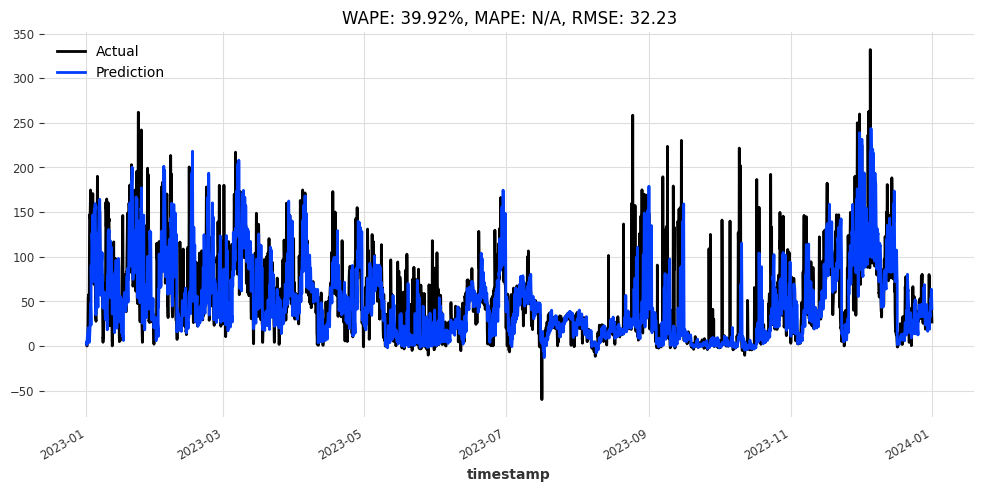

In [29]:
plt.figure(figsize=(12, 5))
actual_ts.plot(label='Actual')
prediction_ts.plot(label='Prediction')

plt.title('WAPE: {:.2f}%, MAPE: N/A, RMSE: {:.2f}'.format(wape(actual_ts, prediction_ts), rmse(actual_ts, prediction_ts)))
plt.legend()